 **# Leaky ReLU와 Sigmoid 성능 비교**



GPU를 설정했으면 library들을 import합니다.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

다음은 dataset을 준비합니다.
CIFAR10 데이터셋 다운로드

In [3]:
transform = transforms.ToTensor()

# MNIST에서 CIFAR10으로 변경
trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)


100%|██████████| 170498071/170498071 [00:08<00:00, 20645658.32it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


데이터셋 데이터 확인

50000
torch.Size([3, 32, 32]) 6


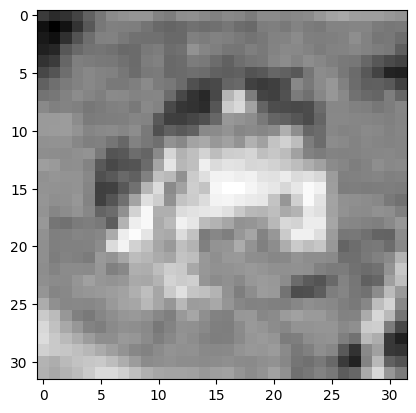

In [4]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')


다음은 SGD를 위해 dataset을 여러 개의 batch로 나누는 과정을 PyTorch로 구현한 모습입니다.

In [5]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)


PyTorch에서는 `DataLoader`가 dataset을 인자로 받아 batch로 나눠줍니다.
부가적으로 `batch_size`라는 인자를 통해 batch size를 받고 있으며, `shuffle`이라는 인자를 통해 data들을 섞을지 결정해줍니다.
우리는 SGD가 완전 랜덤으로 batch를 구성해야 잘 동작하는 것을 알고 있기 때문에 `shuffle`에 `True`를 넘겨주고 있습니다.

다음은 첫 번째 batch를 출력한 모습입니다.

In [6]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)


torch.Size([256, 3, 32, 32]) torch.Size([256])


`images`는 첫 번째 batch의 image들이고 `labels`는 첫 번째 batch의 label들입니다.
위에서 batch size를 64로 설정했기 때문에 총 64개의 image와 label들이 있어야 합니다.
실제 shape 출력 결과를 보면 그렇다는 것을 알 수 있습니다.

다음은 (n, 1, 28, 28) shape의 image를 입력받아 0~9 사이의 정수 하나를 출력하는 3-layer MLP를 구현합니다.

In [7]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim,act_type):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)
    self.act_type = act_type

    #구분값에 따라 Leaky ReLU와 Sigmoid 선택
    if  act_type == 'l':
      self.act = nn.LeakyReLU()
    else:
      self.act = nn.Sigmoid()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x)

    return x


model1 = Model(32 * 32 * 3, 128,'l')
model2 = Model(32 * 32 * 3, 128,'s')

이전의 2-layer MLP와 유사한 형태임을 알 수 있습니다.
여기서 특이사항은 `forward`의 첫 번째 줄에 `torch.flatten`을 사용한다는 것입니다.
`Linear`는 이전에도 봤다시피 (n, d) 형태의 shape을 입력받습니다.
이미지는 (n, 1, 28, 28)이기 때문에 (n, 1 * 28 * 28)로 shape을 변환해야 선형 함수에 입력으로 주어줄 수 있게 됩니다.
이 역할을 수행하는 것이 바로 `torch.flatten`입니다.
우리는 첫 번째 shape인 n을 보존할 것이기 때문에 flatten할 차원은 `start_dim=1`로 넘겨주게 됩니다.

다음은 gradient descent를 수행해줄 optimizer를 구현하는 모습입니다.

In [8]:
from torch.optim import SGD,Adam

lr = 0.001

model1 = model1.to('cuda')
model2 = model2.to('cuda')
# Leaky ReLU와 Sigmoid optimizer adam으로 설정
optimizer_lr = Adam(model1.parameters(), lr=lr)
optimizer_sm = Adam(model2.parameters(), lr=lr)

이전 코드와 거의 똑같습니다. 다른 점은 `model.to('cuda')` 코드를 통해 우리가 구현한 model을 GPU로 옮긴 것입니다.
MNIST 부터는 모델과 data가 커지면서 훨씬 많은 행렬 연산이 이루어지기 때문에 GPU를 활용하는 것이 빠릅니다.

다음은 model을 MNIST에 학습하는 코드입니다.

Epoch   0 | LeakyReLU Accuracy: 45.2280% | Sigmoid Accuracy: 41.3820%
Epoch   0 | LeakyReLU Loss: 0.6187% | Sigmoid Loss: 0.6508%
Epoch   1 | LeakyReLU Accuracy: 46.4920% | Sigmoid Accuracy: 42.7560%
Epoch   1 | LeakyReLU Loss: 0.6004% | Sigmoid Loss: 0.6311%
Epoch   2 | LeakyReLU Accuracy: 46.4220% | Sigmoid Accuracy: 44.9540%
Epoch   2 | LeakyReLU Loss: 0.5901% | Sigmoid Loss: 0.6175%
Epoch   3 | LeakyReLU Accuracy: 48.9740% | Sigmoid Accuracy: 44.8300%
Epoch   3 | LeakyReLU Loss: 0.5765% | Sigmoid Loss: 0.6027%
Epoch   4 | LeakyReLU Accuracy: 48.7060% | Sigmoid Accuracy: 45.6880%
Epoch   4 | LeakyReLU Loss: 0.5678% | Sigmoid Loss: 0.5947%
Epoch   5 | LeakyReLU Accuracy: 49.8800% | Sigmoid Accuracy: 46.7380%
Epoch   5 | LeakyReLU Loss: 0.5603% | Sigmoid Loss: 0.5865%
Epoch   6 | LeakyReLU Accuracy: 49.6260% | Sigmoid Accuracy: 47.6040%
Epoch   6 | LeakyReLU Loss: 0.5533% | Sigmoid Loss: 0.5783%
Epoch   7 | LeakyReLU Accuracy: 51.3120% | Sigmoid Accuracy: 48.4060%
Epoch   7 | LeakyReL

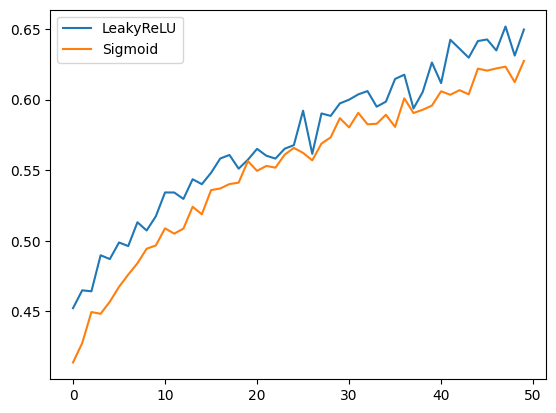

In [10]:
import numpy as np

def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

def plot_acc(train_accs, test_accs, label1='LeakyReLU', label2='Sigmoid'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()


n_epochs = 50
train_accs_lr = []
train_accs_sm = []

for epoch in range(n_epochs):
  total_train_loss_lr = 0.
  total_train_loss_sm = 0.

  for data in trainloader:

    # Leaky ReLU
    model1.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')
    preds = model1(inputs)
    loss = nn.CrossEntropyLoss()(preds, labels)
    loss.backward()
    optimizer_lr.step()
    total_train_loss_lr += loss.item()

    # Sigmoid
    model2.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')
    preds = model2(inputs)
    loss = nn.CrossEntropyLoss()(preds, labels)
    loss.backward()
    optimizer_sm.step()
    total_train_loss_sm += loss.item()



  lr_acc = accuracy(model1, trainloader)
  sm_acc = accuracy(model2, trainloader)

  train_accs_lr.append(lr_acc)
  train_accs_sm.append(sm_acc)


  print(f"Epoch {epoch:3d} | LeakyReLU Accuracy: {lr_acc * 100 :.4f}% | Sigmoid Accuracy: {sm_acc * 100:.4f}%")
  print(f"Epoch {epoch:3d} | LeakyReLU Loss: {total_train_loss_lr / len(trainloader.dataset)*100  :.4f}% | Sigmoid Loss: {total_train_loss_sm / len(trainloader.dataset)*100:.4f}%")

plot_acc(train_accs_lr, train_accs_sm)



출력 결과를 보면 잘 수렴하는 것을 볼 수 있습니다.
이전 구현과 다른 점은 다음 두 가지입니다.
- `for data in trainloader`를 통해 batch들을 iterate하면서 model을 학습합니다.
- `inputs, labels = inputs.to('cuda'), labels.to('cuda')`를 통해 model의 입력으로 들어가는 tensor들을 GPU로 보냅니다.

마지막으로 첫 번째 data에 대한 예측 결과를 살펴봅시다.

In [ ]:
idx = 0

x = trainset[idx][0][None]  # (1, 1, 28, 28)
x = x.to('cuda')

print(model(x))
print(trainset[idx][1])

여기서 idx를 조정하여 다른 data에 대한 출력 결과도 볼 수 있습니다.
예측 결과를 보시면 아직 성능이 그렇게 좋지 않은 것을 알 수 있습니다.